In [95]:
import numpy as np
import pandas as pd
import os
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [96]:
departures_path = r'D:\Summer Practicum\1_Data\heatmaps\departures'
arrivals_path = r'D:\Summer Practicum\1_Data\heatmaps\arrivals'

# Custom colormap
colors = ["#FFFFFF", "#DEEEF6", "#E19B8C", "#CB5017", "#9C2C19"]
custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors, N=256)

In [97]:
def simplify_timeblock(block):
    try:
        start_str, end_str = block.split('-')
        start_hour = int(start_str[:2])
        end_hour = int(end_str[:2]) + 1  # inclusive hour range

        def h12(h):
            suffix = "AM" if h < 12 or h == 24 else "PM"
            h = h % 12
            return (12 if h == 0 else h), suffix

        sh, suffix1 = h12(start_hour)
        eh, suffix2 = h12(end_hour % 24)

        # If both ends are same period (AM/PM)
        if suffix1 == suffix2:
            return f"{sh}–{eh} {suffix1}"
        else:
            return f"{sh} {suffix1}–{eh} {suffix2}"
    except Exception:
        return block

# Departures

In [98]:
# Combine all departure timeblock delays into a single dataframe
departure_files = []
for filename in os.listdir(departures_path):
    if filename.endswith('_delay_data.csv'):
        file_path = os.path.join(departures_path, filename)
        df = pd.read_csv(file_path, index_col=0)
        departure_files.append(df)

# Combine into a single dataframe and get the overall mean delay to compare later
dep_df = pd.concat(departure_files)
avg_dep_delay = int(pd.to_numeric(dep_df["DelayAvg"], errors='coerce').mean())

In [99]:
# Calculate each airline's mean delay
mean_delays = dep_df.groupby('Operating_Airline ')['DelayAvg'].mean()

# Flag above-average delays
dep_df['AboveAvg'] = dep_df.apply(
    lambda row: row['DelayAvg'] > 40, axis=1
)
divnorm = TwoSlopeNorm(vmin=0, vcenter=4, vmax=10)

In [100]:
# Count how many airlines were above average for each timeblock-day
summary_df = (
    dep_df.groupby(['DepTimeBlk', 'DayOfWeek'])['AboveAvg']
    .sum()
    .reset_index(name='AboveAvgCount')
)

Pivot to heatmap format

In [101]:
heatmap_df = summary_df.pivot(index='DepTimeBlk', columns='DayOfWeek', values='AboveAvgCount')

# Sort timeblocks and days of week
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_df = heatmap_df[day_order]
heatmap_df = heatmap_df.sort_index()
heatmap_df.index = heatmap_df.index.map(simplify_timeblock)

## Plot

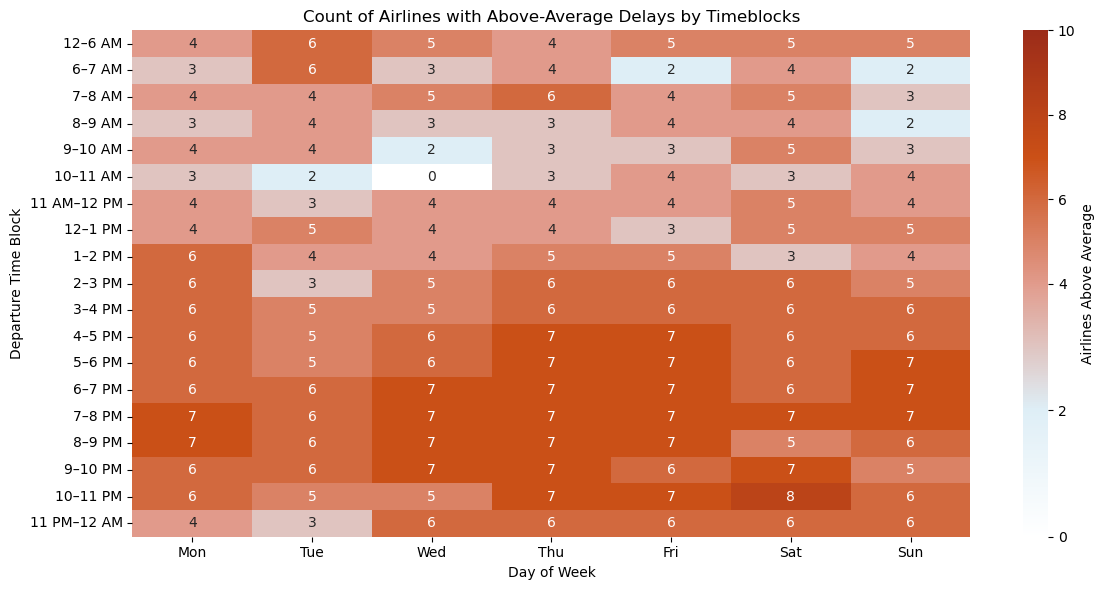

In [102]:
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap=custom_cmap, norm=divnorm, cbar_kws={'label': 'Airlines Above Average'})
plt.title('Count of Airlines with Above-Average Delays by Timeblocks')
plt.xlabel('Day of Week')
plt.ylabel('Departure Time Block')
plt.tight_layout()
plt.show()

# Arrivals

In [103]:
# Combine all departure timeblock delays into a single dataframe
arrival_files = []
for filename in os.listdir(arrivals_path):
    if filename.endswith('_delay_data.csv'):
        file_path = os.path.join(arrivals_path, filename)
        df = pd.read_csv(file_path, index_col=0)
        arrival_files.append(df)

# Combine into a single dataframe and get the overall mean delay to compare later
arr_df = pd.concat(arrival_files)
avg_dep_delay = int(pd.to_numeric(arr_df["DelayAvg"], errors='coerce').mean())

In [104]:
# Calculate each airline's mean delay
mean_delays = arr_df.groupby('Operating_Airline ')['DelayAvg'].mean()

# Flag above-average delays
arr_df['AboveAvg'] = arr_df.apply(
    lambda row: row['DelayAvg'] > 40, axis=1
)

In [105]:
# Count how many airlines were above average for each timeblock-day
summary_df = (
    arr_df.groupby(['ArrTimeBlk', 'DayOfWeek'])['AboveAvg']
    .sum()
    .reset_index(name='AboveAvgCount')
)

In [106]:
heatmap_df = summary_df.pivot(index='ArrTimeBlk', columns='DayOfWeek', values='AboveAvgCount')

# Sort timeblocks and days of week
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_df = heatmap_df[day_order]
heatmap_df = heatmap_df.sort_index()
heatmap_df.index = heatmap_df.index.map(simplify_timeblock)

## Plot

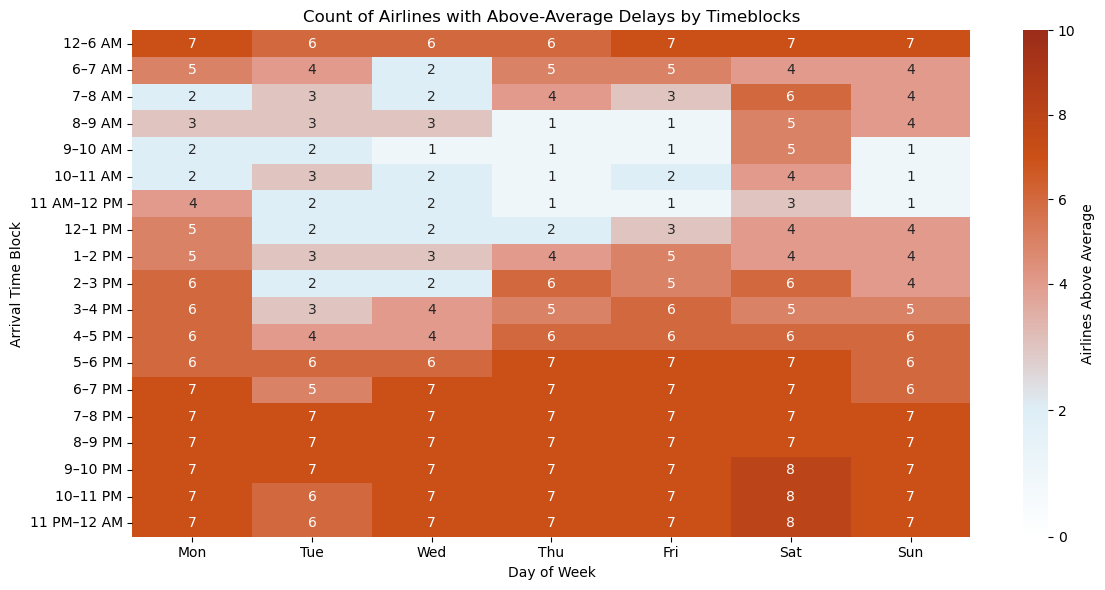

In [107]:
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap=custom_cmap, norm=divnorm, cbar_kws={'label': 'Airlines Above Average'})
plt.title('Count of Airlines with Above-Average Delays by Timeblocks')
plt.xlabel('Day of Week')
plt.ylabel('Arrival Time Block')
plt.tight_layout()
plt.show()